## EE641 Final Project - Plant Disease Detection using ViT
- Class: EE641 – Deep Learning Systems
- Topic: Plant Disease Detection
- Team: Kaisen Ye, Reshma Nawaz

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### ViT Model
- Patch Extraction: Extract patches from input images and project them to a dense representation.
- Positional Embedding: To help the model understand the order of patches.
- Transformer Blocks: Consist of multi-head attention, layer normalization, and a feed-forward MLP network.


In [2]:
class VisionTransformer(Model):
    def __init__(self, num_classes, image_size=224, patch_size=16, num_patches=196, d_model=64, num_heads=4, mlp_dim=128, num_layers=6, dropout=0.1):
        super(VisionTransformer, self).__init__()
        
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size * 3
        self.d_model = d_model
        
        # Layers for embedding
        self.patch_projection = layers.Dense(d_model)
        self.position_embedding = layers.Embedding(input_dim=self.num_patches, output_dim=d_model)
        
        # Transformer blocks
        self.transformer_blocks = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]
        
        # MLP Head
        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.GlobalAveragePooling1D(),
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(num_classes, activation='softmax')
        ])

    def extract_patches(self, images, patch_size):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        patches = self.extract_patches(inputs, patch_size=int(np.sqrt(self.patch_dim / 3)))
        patches = self.patch_projection(patches)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        embedded_patches = patches + self.position_embedding(positions)
        
        x = embedded_patches
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        return self.mlp_head(x)

class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, mlp_dim, dropout):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(d_model),
            layers.Dropout(dropout)
        ])

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.norm1(inputs + attn_output)
        mlp_output = self.mlp(out1)
        return self.norm2(out1 + mlp_output)

### Data Preprocessing

In [3]:
# Dataset Paths
data_dir = "/kaggle/input/plant-disease-recognition-dataset"
image_size = 224

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dataset = train_datagen.flow_from_directory(
    f'{data_dir}/Train/Train',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='sparse'
)
val_dataset = val_datagen.flow_from_directory(
    f'{data_dir}/Validation/Validation',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='sparse'
)
test_dataset = test_datagen.flow_from_directory(
    f'{data_dir}/Test/Test',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='sparse'
)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


### Hyperparameters and Model Compile

In [4]:
# Set parameters
num_classes = 3  # Only 3 classes: Healthy, Powdery, Rust
patch_size = 16
num_patches = (image_size // patch_size) ** 2

d_model = 64
num_heads = 4
mlp_dim = 128
num_layers = 6

dropout_rate = 0.1

# Initialize the model
vit_model = VisionTransformer(num_classes=num_classes,
                              image_size=image_size,
                              patch_size=patch_size,
                              num_patches=num_patches,
                              d_model=d_model,
                              num_heads=num_heads,
                              mlp_dim=mlp_dim,
                              num_layers=num_layers,
                              dropout=dropout_rate)
# Compile the model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Check if GPU available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Training

In [5]:
history = vit_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734294526.181605      88 service.cc:145] XLA service 0x78ed1c050590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734294526.181668      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/42 ━━━━━━━━━━━━━━━━━━━━ 28:22 42s/step - accuracy: 0.3438 - loss: 1.1607

I0000 00:00:1734294533.174057      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.3633 - loss: 1.1321 - val_accuracy: 0.3333 - val_loss: 1.1146
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3393 - loss: 1.1002 - val_accuracy: 0.3833 - val_loss: 1.0614
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5111 - loss: 0.9768 - val_accuracy: 0.4500 - val_loss: 0.9758
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5577 - loss: 0.9003 - val_accuracy: 0.4000 - val_loss: 1.0410
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5530 - loss: 0.8786 - val_accuracy: 0.4833 - val_loss: 1.0315
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6077 - loss: 0.8364 - val_accuracy: 0.4833 - val_loss: 1.0109
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5810 - loss: 0.8607 - val_accuracy: 0.5333 - val_loss: 0.9661
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5569 - loss: 0.8896 - val_accuracy: 0.5167 - val_loss: 0.9572
Ep

### Training Results

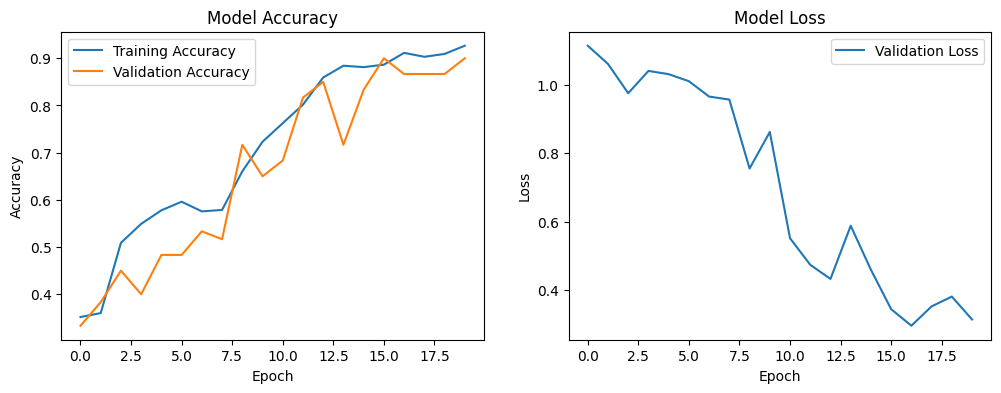

In [6]:
# Plot training accuracy, validation accuracy, and validation loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluate on test set

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8924 - loss: 0.2952
Test Loss: 0.2901151478290558
Test Accuracy: 0.8933333158493042
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<Figure size 1000x800 with 0 Axes>

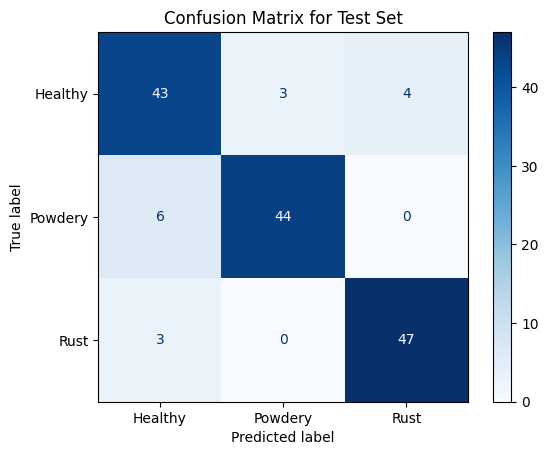

In [7]:
# Evaluate on the test dataset and calculate confusion matrix
test_loss, test_accuracy = vit_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions and true labels for the test set
y_true = []
y_pred = []

# Iterate over the test dataset to collect predictions and true labels
for images, labels in test_dataset:
    preds = vit_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels)

    # Break the loop after one full epoch (test dataset size is fixed)
    if len(y_true) >= test_dataset.samples:
        break

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_dataset.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for Test Set")
plt.show()

### Save model

In [8]:
# Save the model
vit_model.save('/kaggle/working/vit_plant_disease_model.h5')